In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [5]:
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


11490434/11490434 [==============================] - 0s 0us/step


In [2]:
new_model = tf.keras.models.load_model('/content/best_model.h5')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

# Filters / Feature Detectors

conv2d (3, 3, 1, 32)
32


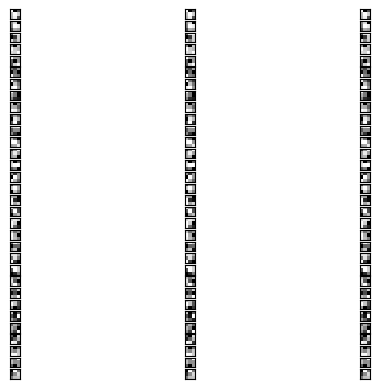

conv2d_1 (3, 3, 32, 64)
64


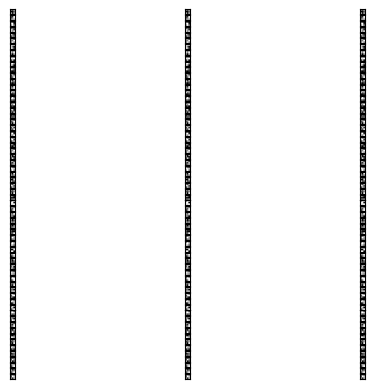

conv2d_2 (3, 3, 64, 128)
128


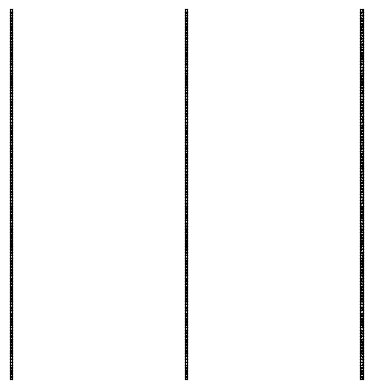

In [3]:
#Iterate thru all the layers of the model
for layer in new_model.layers:
    if 'conv' in layer.name:
        weights, bias = layer.get_weights()
        print(layer.name, weights.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:,0], cmap='gray')
                filter_cnt+=1
        plt.show()

## I have written my **summary** of the layer activation result observations at **"Activation Layers MNIST with Model"** google colab notebook. 

# Real Test Data Fashion-MNIST Activations : 

## Compared to the MNIST Model layer activations, Net model gives higher layer activations which is natural since it also has higher prediction accuracy. 
 
##Feature Maps

313/313 [==============================] - 7s 22ms/step
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(3, 3, 128)


<ipython-input-6-23e509f0ab24>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure( figsize=(scale * n_features, scale) )


(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)


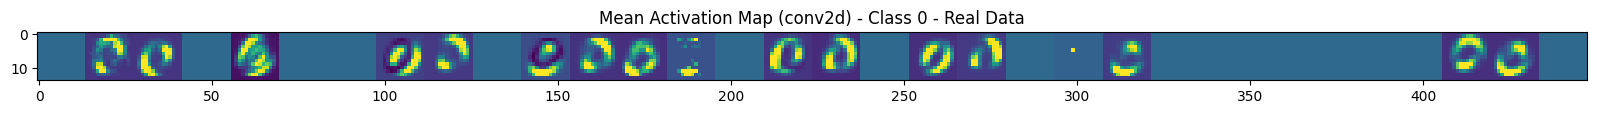

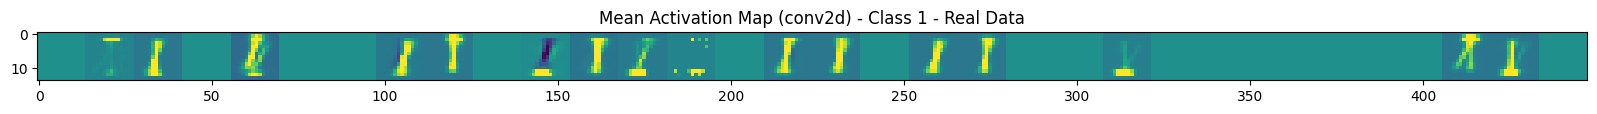

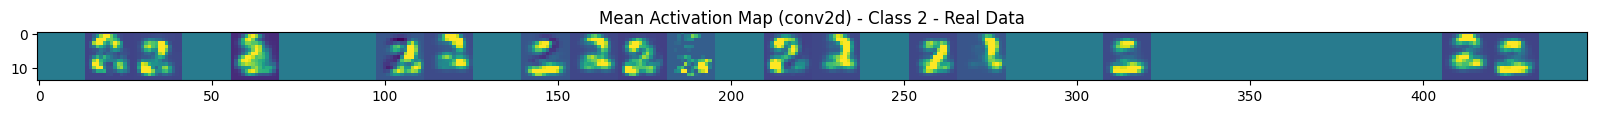

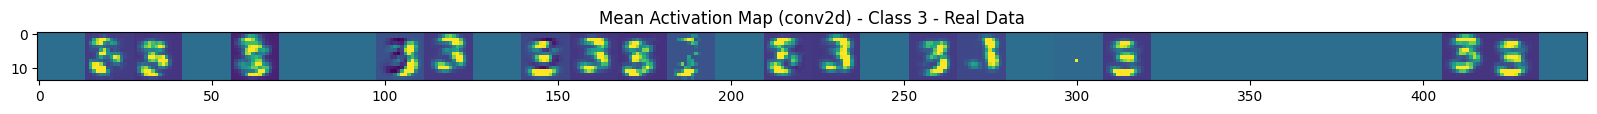

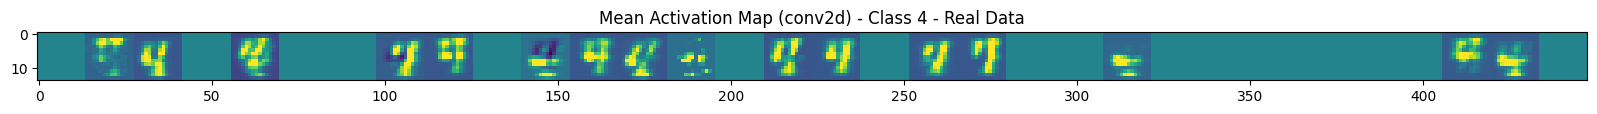

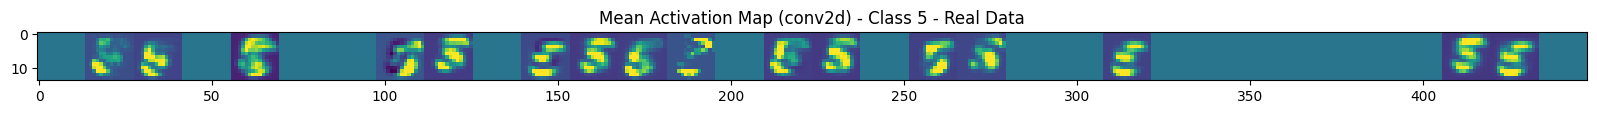

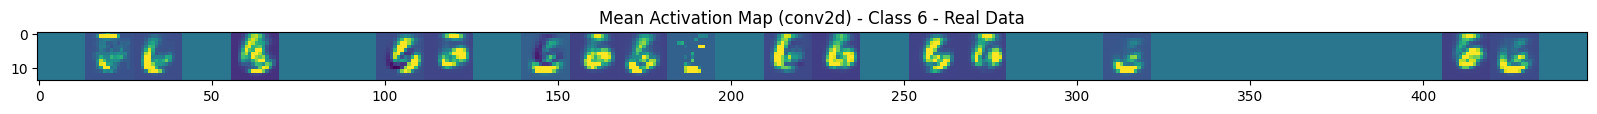

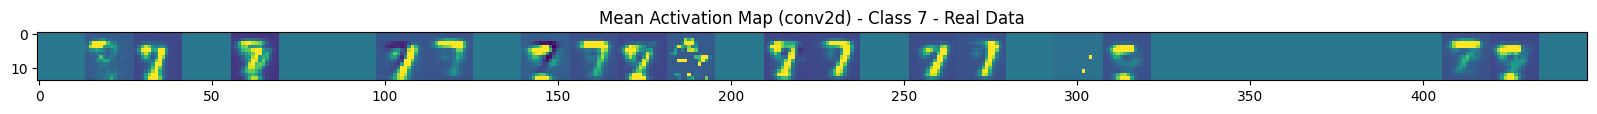

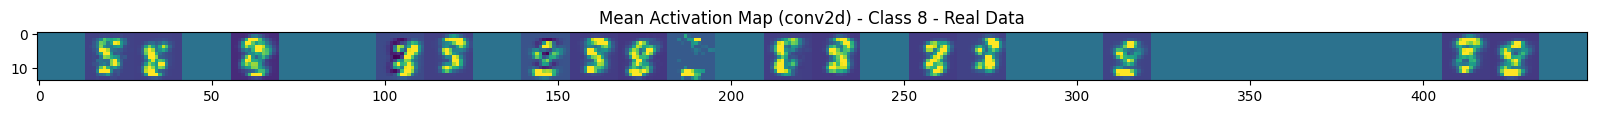

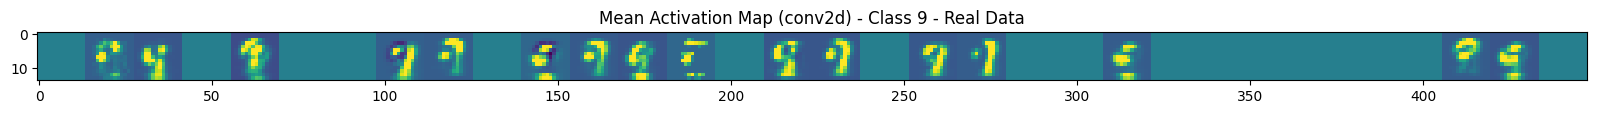

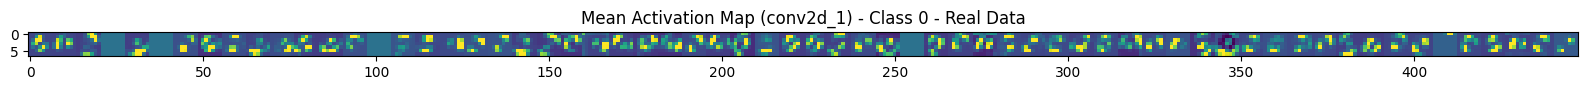

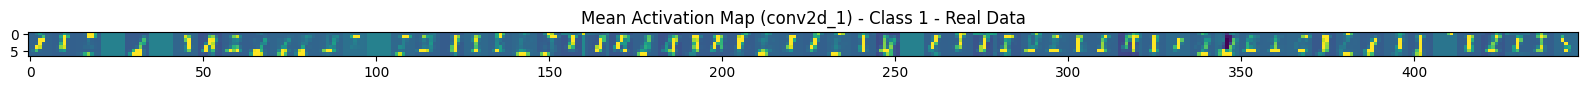

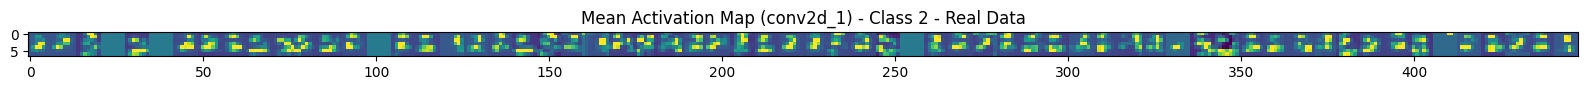

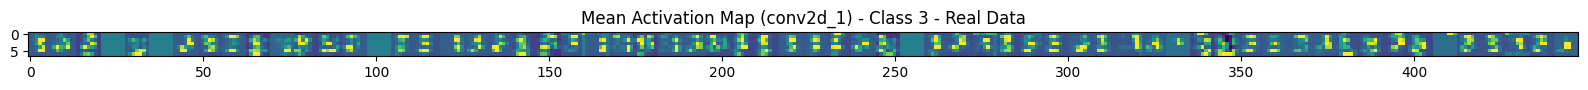

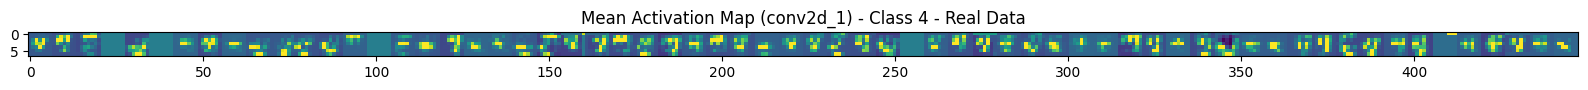

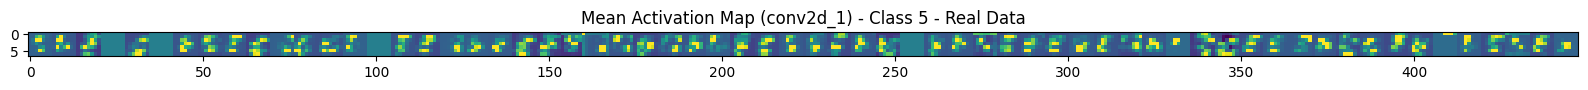

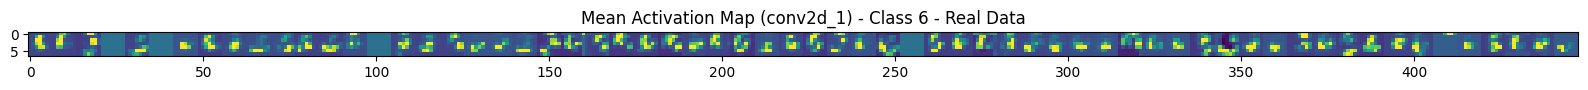

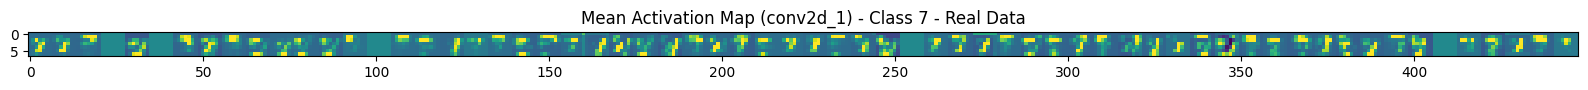

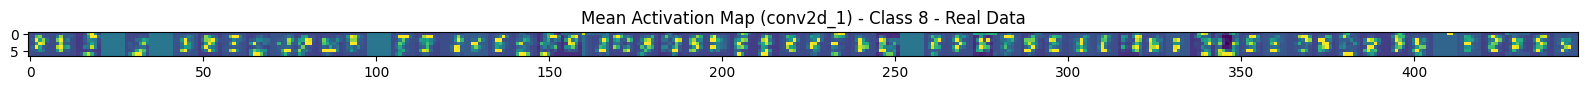

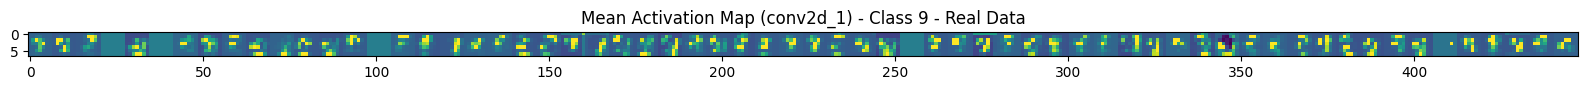

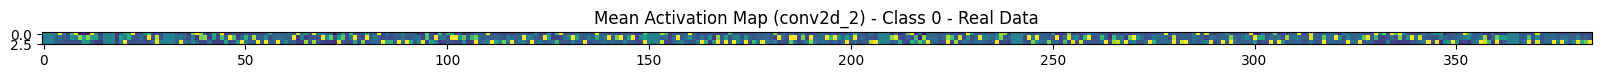

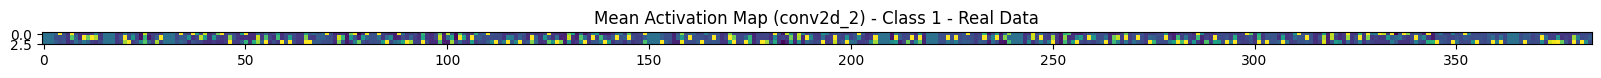

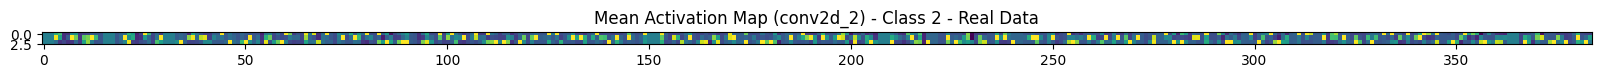

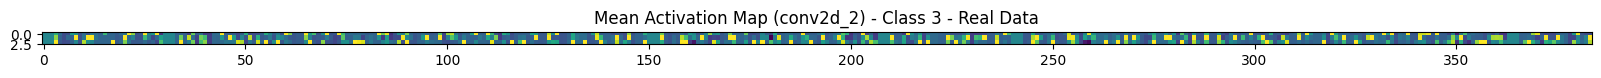

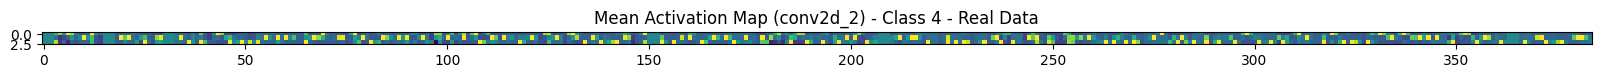

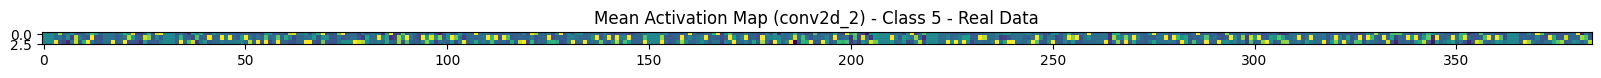

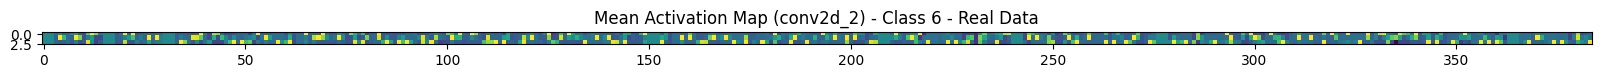

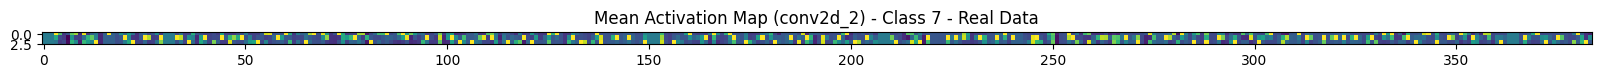

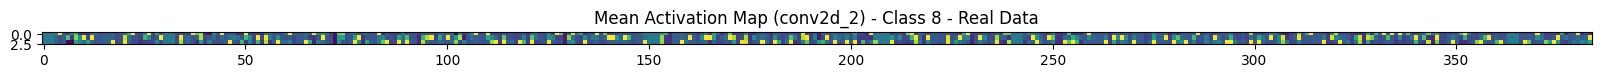

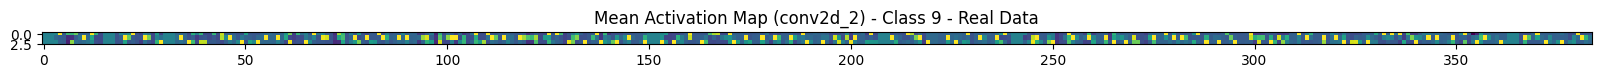

In [6]:
# Create a new array to store the reshaped images
input_images = np.zeros((test_images.shape[0], 28, 28, 1))

# Reshape each image to (1, 28, 28, 1) and store in input_images
for i in range(test_images.shape[0]):
    input_images[i] = test_images[i].reshape(28, 28, 1)

# Define a new Model to get intermediate representations for all layers in the previous model after the first.
successive_outputs = [layer.output for layer in new_model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=new_model.input, outputs=successive_outputs)

# Get the intermediate representations for real data
successive_feature_maps_real = visualization_model.predict(input_images)

# Retrieve the names of the layers
layer_names = [layer.name for layer in new_model.layers]

# Loop over the layers
for layer_name, feature_map_real in zip(layer_names, successive_feature_maps_real):
  if 'conv' not in layer_name:
    continue

  # Get the number of filters in the current layer
  n_filters = feature_map_real.shape[-1]

  # Define the digits to generate noise maps for
  num_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  # Loop over the classes
  for class_idx in num_classes:
    # Select the feature maps that correspond to the target class
    target_indices = np.where(test_labels == class_idx)[0]
    feature_maps_real = feature_map_real[target_indices]

    # Get the mean activation maps for real data and noise data separately
    mean_activation_map_real = np.mean(feature_maps_real, axis=(0))

    print(mean_activation_map_real.shape)
    if len(mean_activation_map_real.shape) == 3:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
      n_features = mean_activation_map_real.shape[-1]  # number of features in the feature map
      size = mean_activation_map_real.shape[1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
      display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
      for i in range(n_features):
          x  = mean_activation_map_real[:, :, i]
          x -= x.mean()
          x_std = x.std()
          x /= (x_std + 1e-7)
          x *=  64
          x += 128
          x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
          display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
      scale = 20. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( f"Mean Activation Map ({layer_name}) - Class {class_idx} - Real Data" )
      plt.grid  ( False )
      plt.imshow( display_grid, aspect='auto', cmap='viridis' )

##Convolutional Layer Activation Bar Plots

313/313 [==============================] - 8s 24ms/step


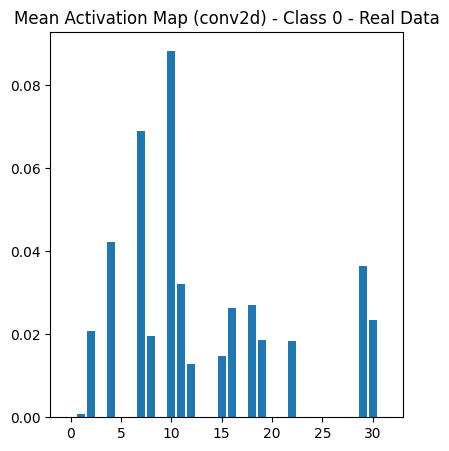

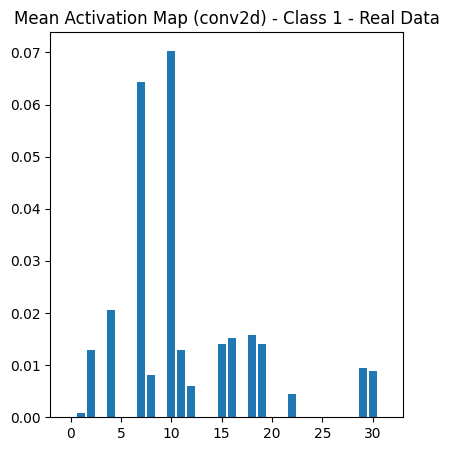

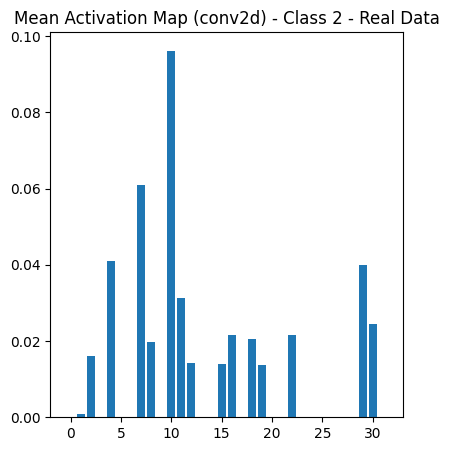

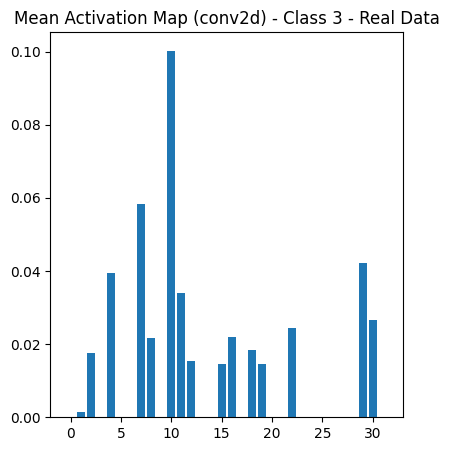

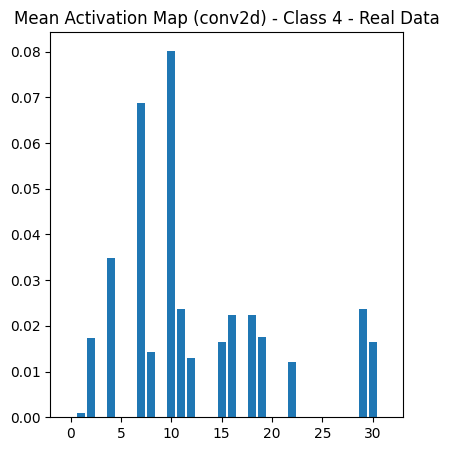

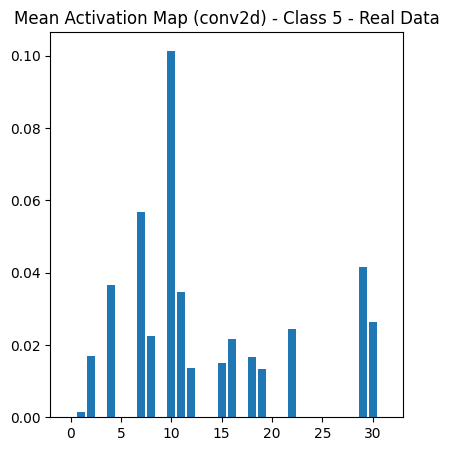

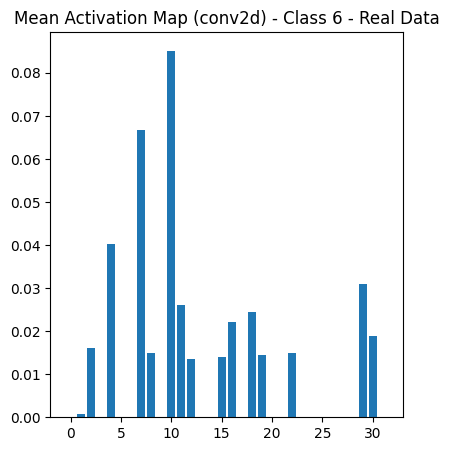

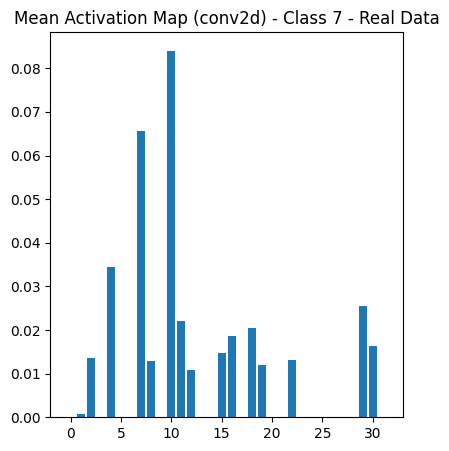

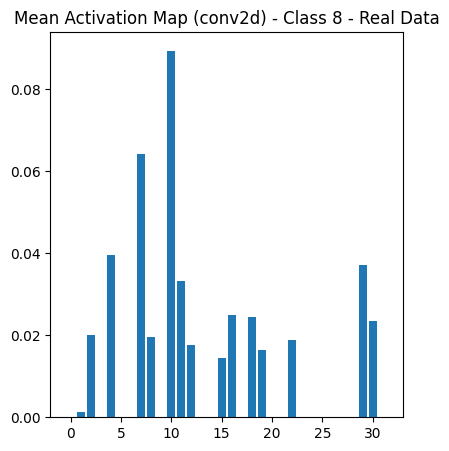

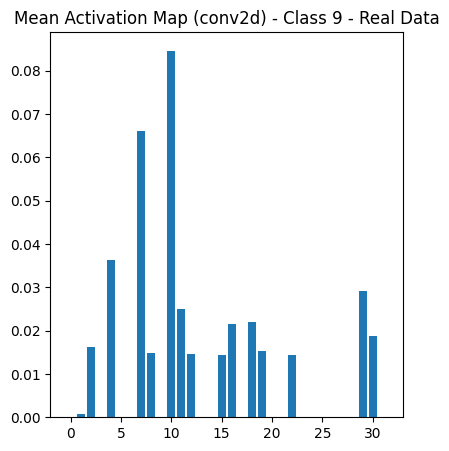

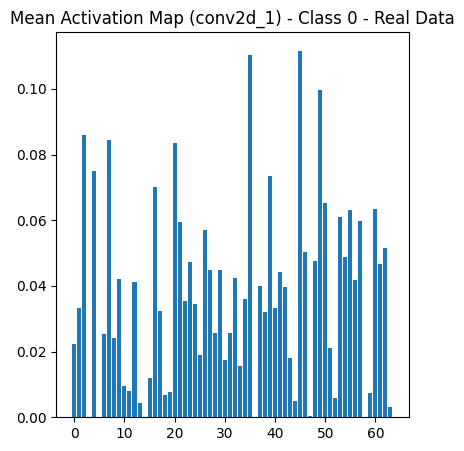

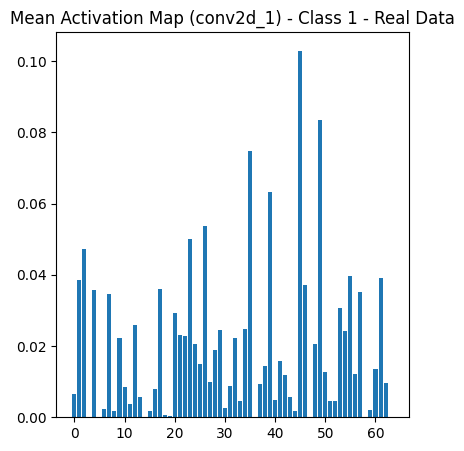

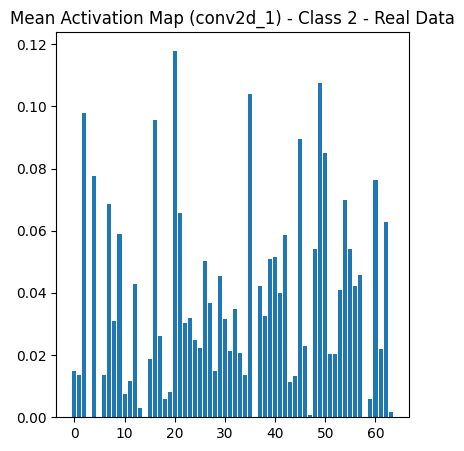

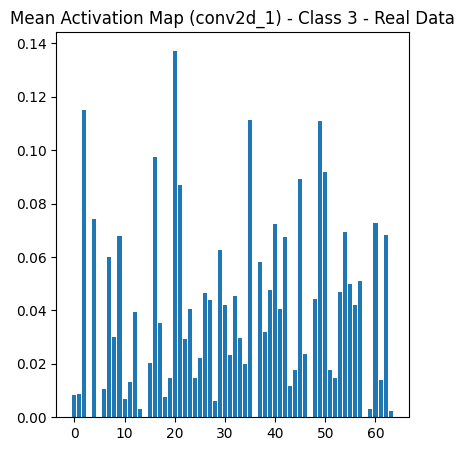

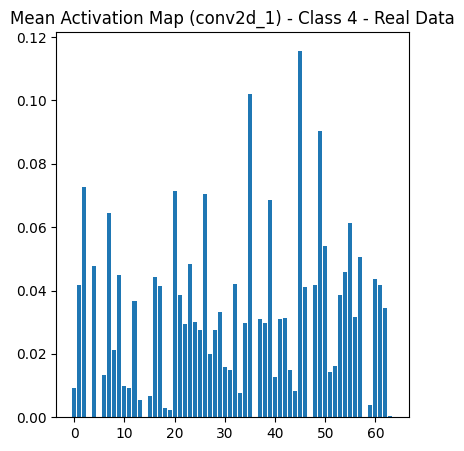

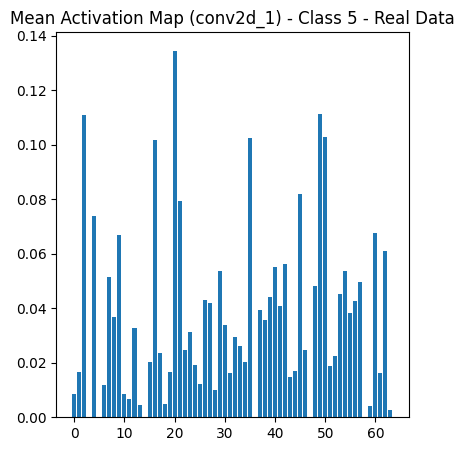

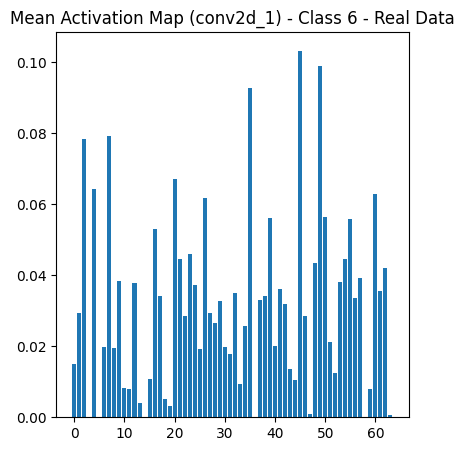

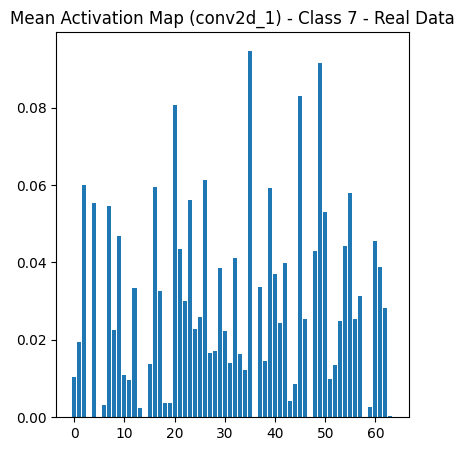

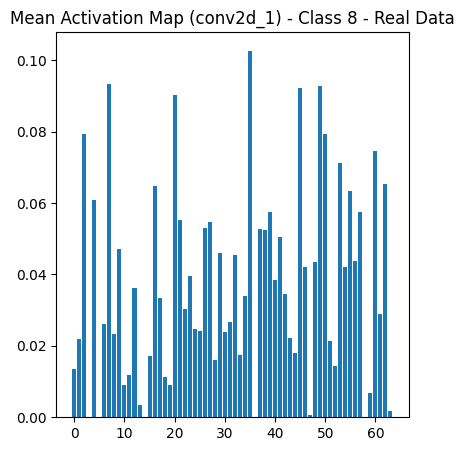

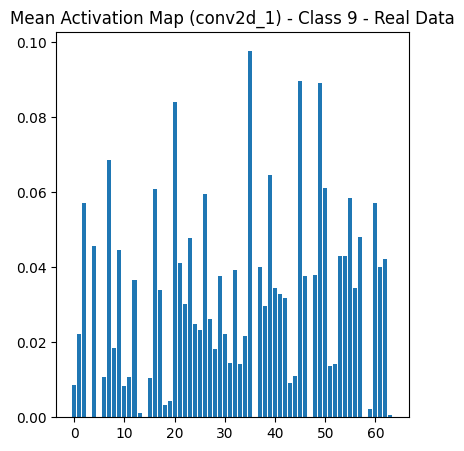

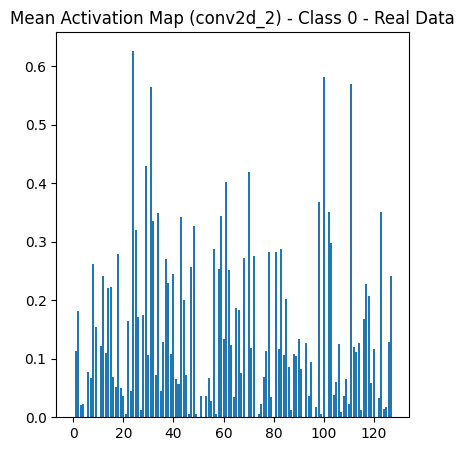

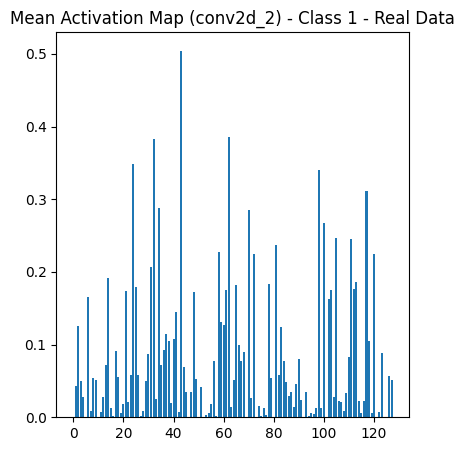

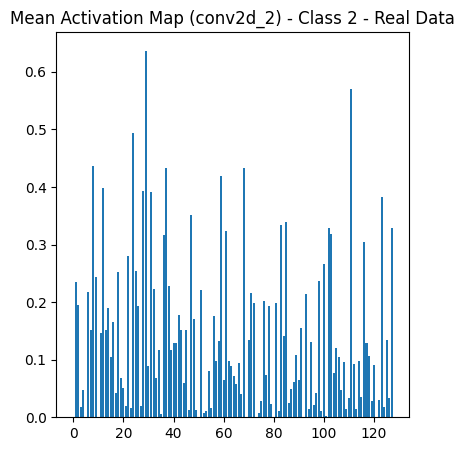

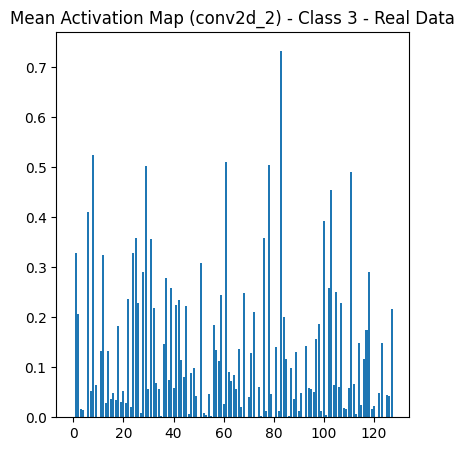

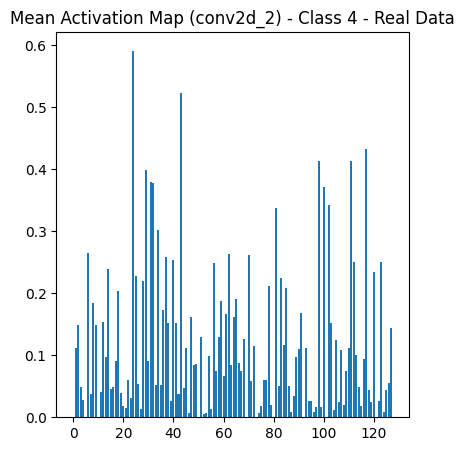

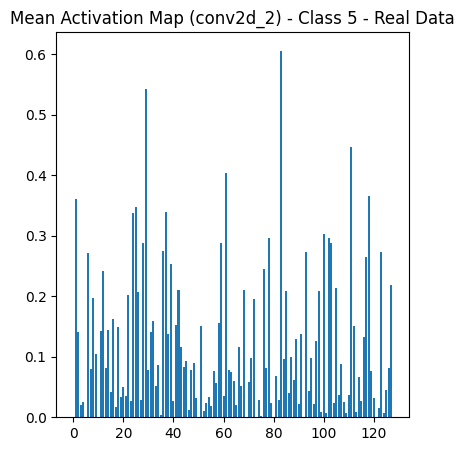

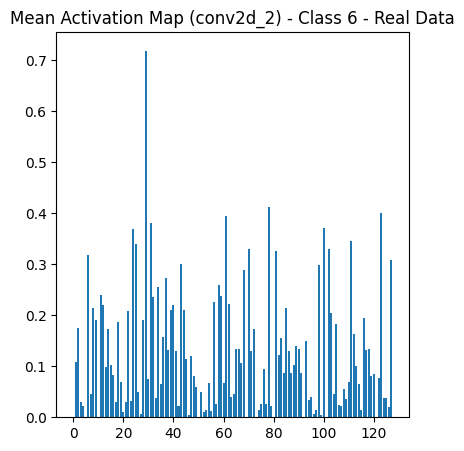

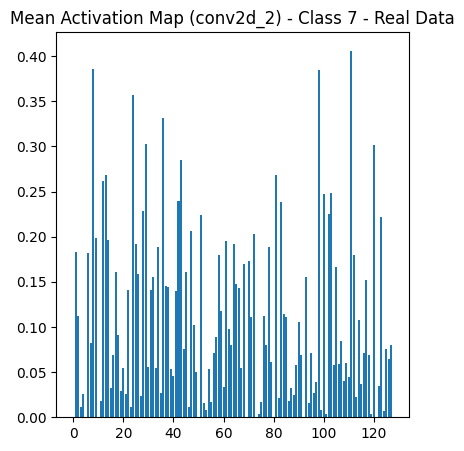

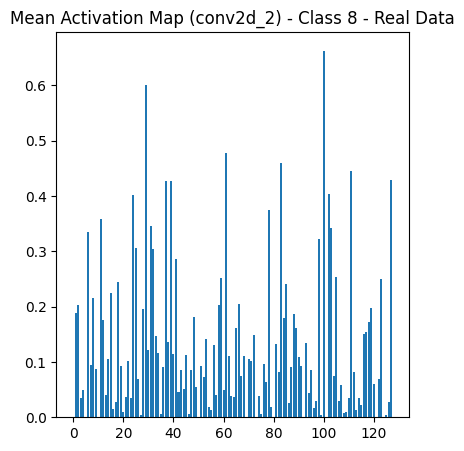

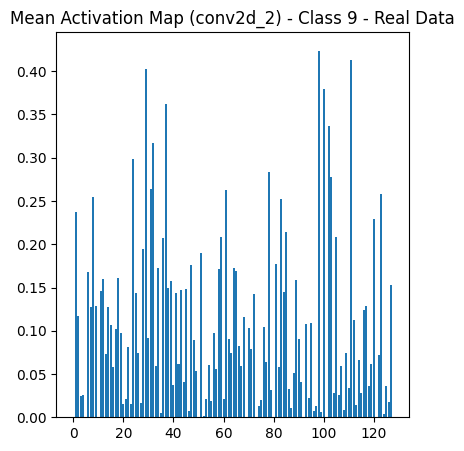

In [7]:
# Define a new Model to get intermediate representations for all layers in the previous model after the first.
successive_outputs = [layer.output for layer in new_model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=new_model.input, outputs=successive_outputs)

# Get the intermediate representations for real data
successive_feature_maps_real = visualization_model.predict(test_images)

# Retrieve the names of the layers
layer_names = [layer.name for layer in new_model.layers]

# Loop over the layers
for layer_name, feature_map_real in zip(layer_names, successive_feature_maps_real):
  if 'conv' not in layer_name:
    continue

  # Get the number of filters in the current layer
  n_filters = feature_map_real.shape[-1]

  # Define the digits to generate noise maps for
  num_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  # Loop over the classes
  for class_idx in num_classes:
    # Select the feature maps that correspond to the target class
    target_indices = np.where(test_labels == class_idx)[0]
    feature_maps_real = feature_map_real[target_indices]

    # Get the mean activation maps for real data and noise data separately
    mean_activation_map_real = np.mean(feature_maps_real, axis=(0,1,2))

    # Plot the mean activation maps for real and noise data side by side
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title(f"Mean Activation Map ({layer_name}) - Class {class_idx} - Real Data")
    plt.bar(range(n_filters), mean_activation_map_real)
    plt.show()


# Noisy image mean activation maps


### The noisy images: all_noise_maps

In [8]:

# Define the gamma value
gamma = 0.2

# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def generate_noise_maps_per_digit(digit, n_samples, gamma, img_shape=(28, 28)):
    noise_maps = []
    labels = []
    mnist_dataset = MNIST(root='data/',train=False, download=True)
    digit_indices = np.where(np.array(mnist_dataset.targets) == digit)[0]
    digit_indices = digit_indices[:n_samples]
    for idx in digit_indices:
        # Get original image
        img = mnist_dataset.data[idx].numpy()
        # Generate random noise
        noise = np.random.randn(*img_shape)
        # Combine noise with original image
        noisy_img = gamma * noise + (1 - gamma) * img
        noise_maps.append(noisy_img)
        labels.append(digit)
    return np.array(noise_maps), np.array(labels)

# Generate noise maps for each digit and average them
noise_maps=[]
labels=[]
for digit in digits:
    digit_noise_maps, digit_labels = generate_noise_maps_per_digit(digit, n_samples, gamma, img_shape=(28,28))
    noise_maps.append(digit_noise_maps)
    labels.append(digit_labels)

all_noise_maps = np.concatenate(noise_maps)
all_labels = np.concatenate(labels)


100%|██████████| 9912422/9912422 [00:00<00:00, 99967807.06it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 81572857.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26452870.60it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3456818.87it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Feature Maps

157/157 [==============================] - 3s 19ms/step
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(14, 14, 32)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(7, 7, 64)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)


<ipython-input-9-0c377bd677ad>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure( figsize=(scale * n_features, scale) )


(3, 3, 128)
(3, 3, 128)
(3, 3, 128)
(3, 3, 128)


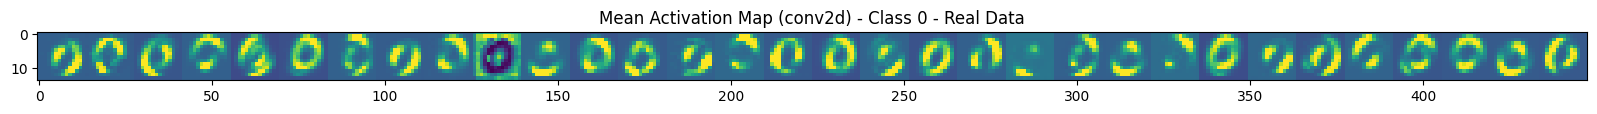

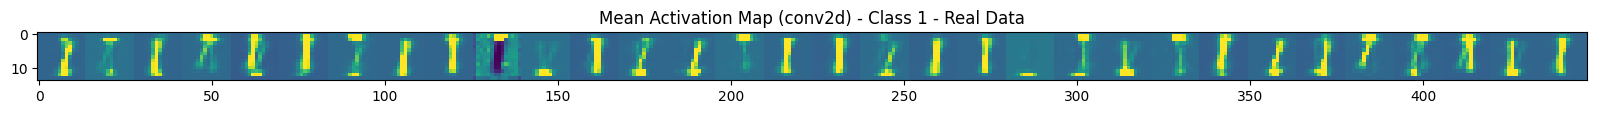

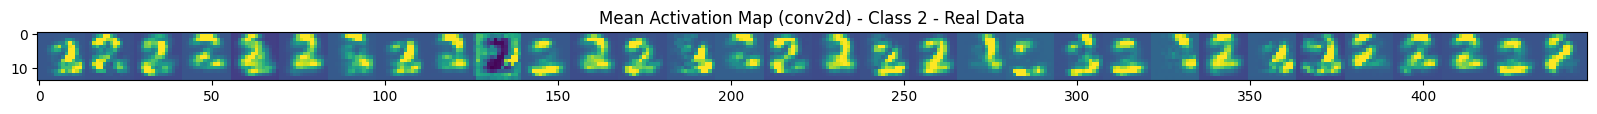

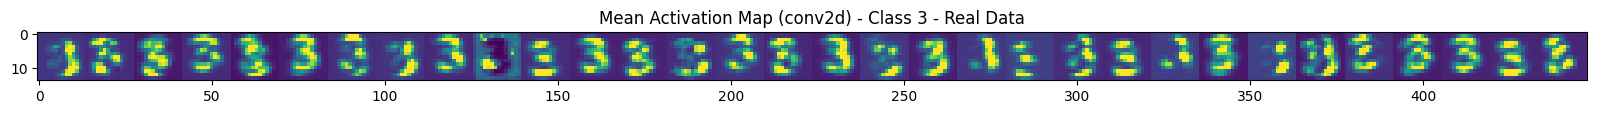

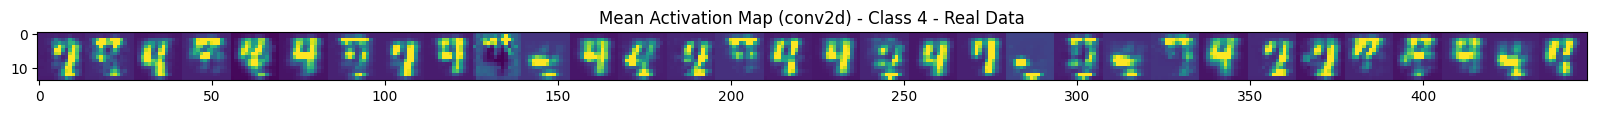

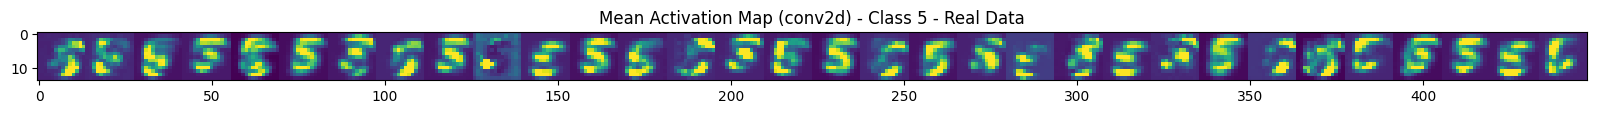

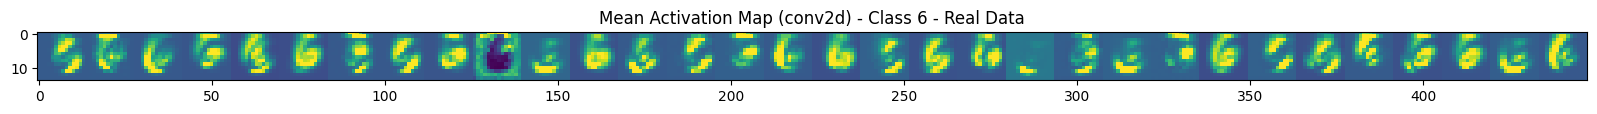

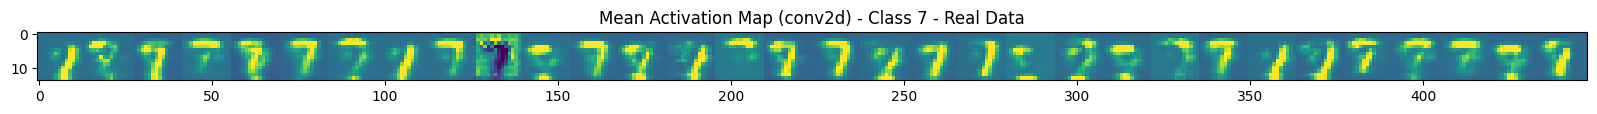

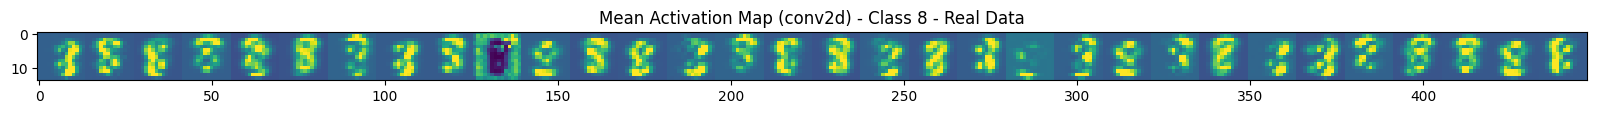

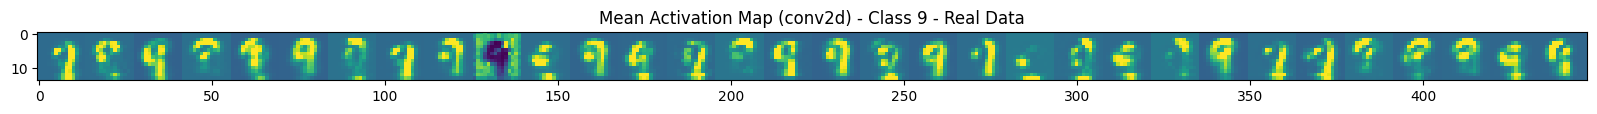

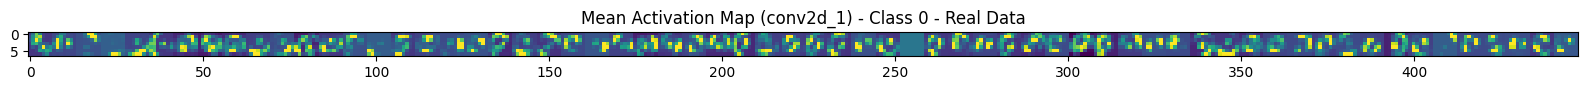

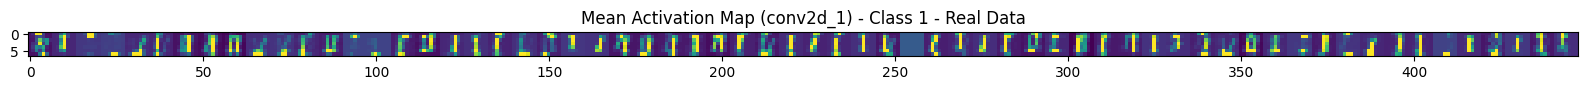

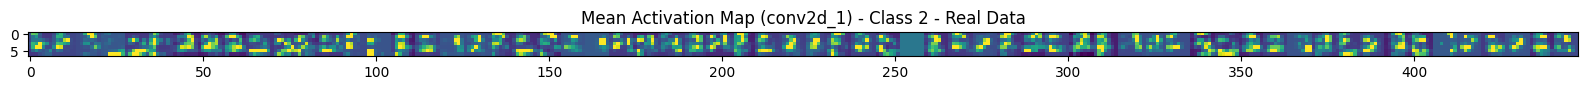

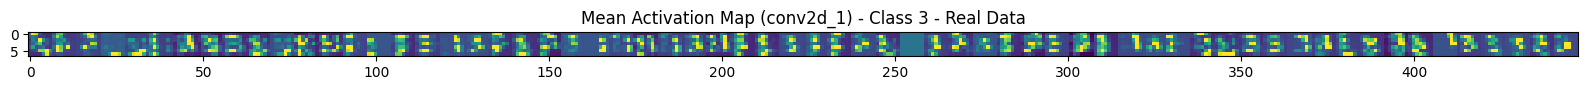

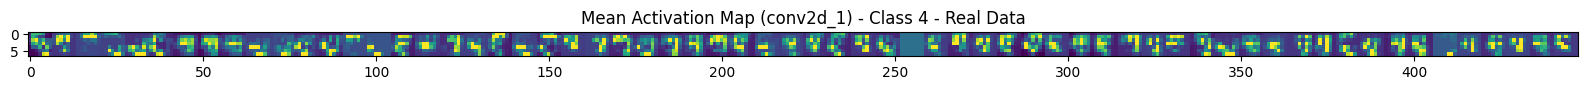

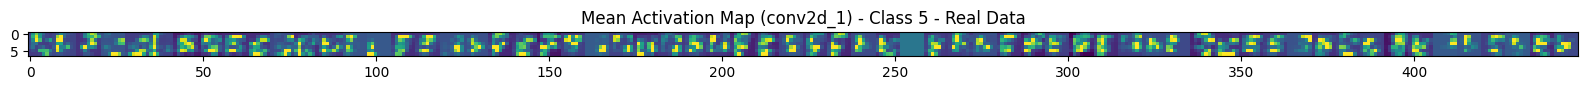

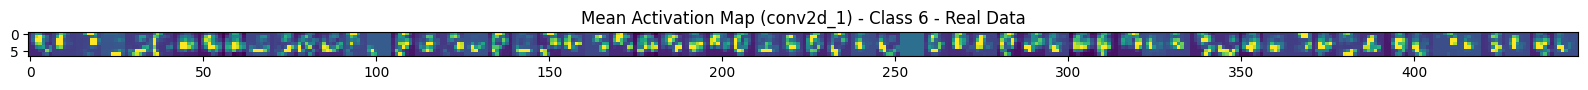

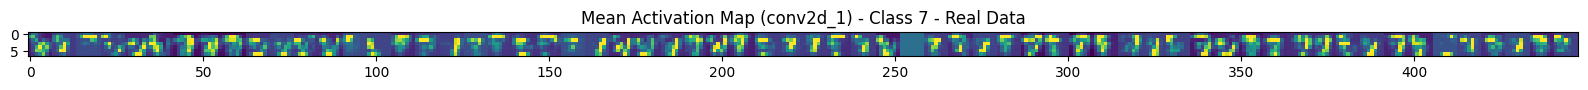

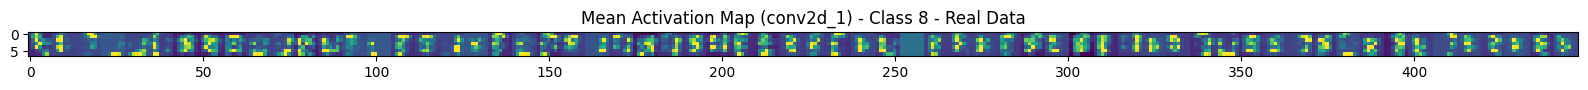

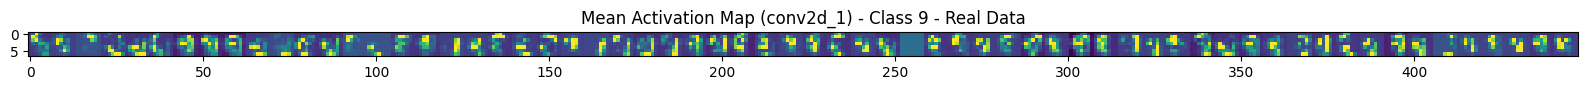

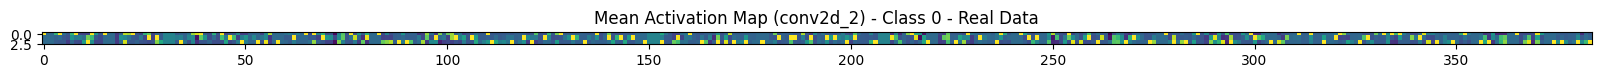

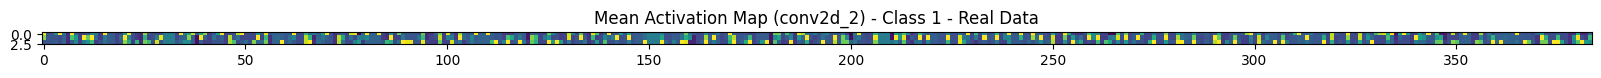

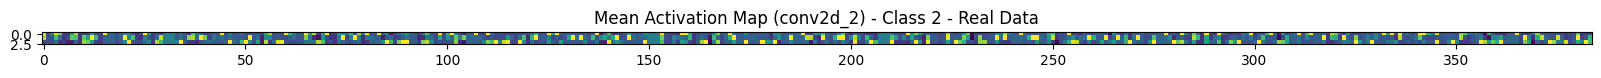

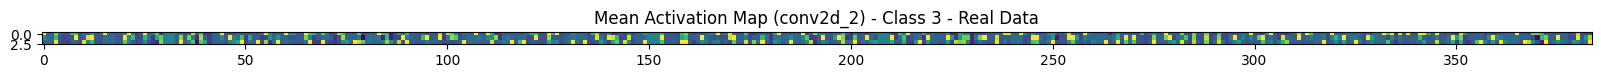

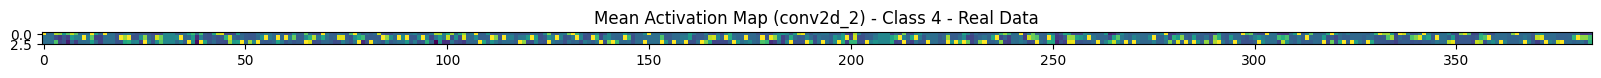

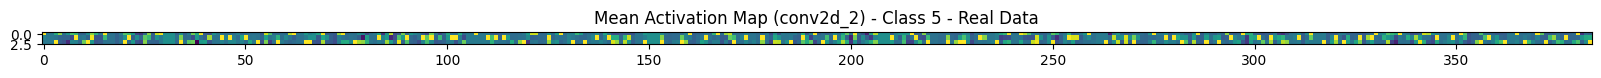

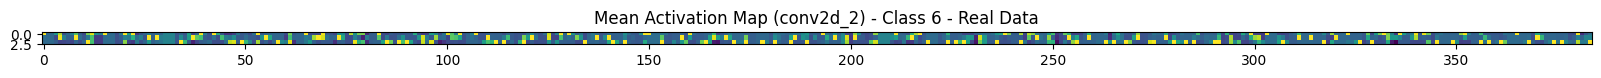

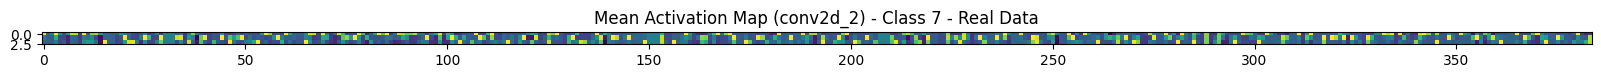

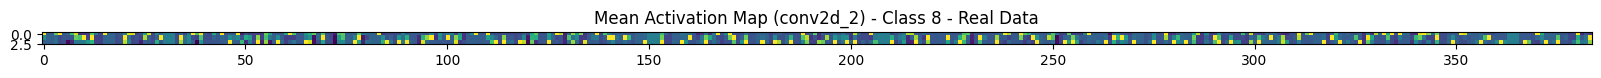

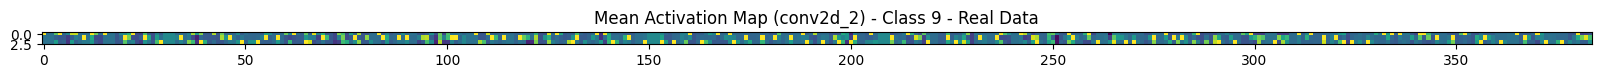

In [9]:
# Create a new array to store the reshaped images
input_images = np.zeros((all_noise_maps.shape[0], 28, 28, 1))

# Reshape each image to (1, 28, 28, 1) and store in input_images
for i in range(all_noise_maps.shape[0]):
    input_images[i] = all_noise_maps[i].reshape(28, 28, 1)

# Define a new Model to get intermediate representations for all layers in the previous model after the first.
successive_outputs = [layer.output for layer in new_model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=new_model.input, outputs=successive_outputs)

# Get the intermediate representations for real data
successive_feature_maps_real = visualization_model.predict(input_images)

# Retrieve the names of the layers
layer_names = [layer.name for layer in new_model.layers]

# Loop over the layers
for layer_name, feature_map_real in zip(layer_names, successive_feature_maps_real):
  if 'conv' not in layer_name:
    continue

  # Get the number of filters in the current layer
  n_filters = feature_map_real.shape[-1]

  # Define the digits to generate noise maps for
  num_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  # Loop over the classes
  for class_idx in num_classes:
    # Select the feature maps that correspond to the target class
    target_indices = np.where(all_labels == class_idx)[0]
    feature_maps_real = feature_map_real[target_indices]

    # Get the mean activation maps for real data and noise data separately
    mean_activation_map_real = np.mean(feature_maps_real, axis=(0))

    print(mean_activation_map_real.shape)
    if len(mean_activation_map_real.shape) == 3:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
      n_features = mean_activation_map_real.shape[-1]  # number of features in the feature map
      size = mean_activation_map_real.shape[1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
      display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
      for i in range(n_features):
          x  = mean_activation_map_real[:, :, i]
          x -= x.mean()
          x_std = x.std()
          x /= (x_std + 1e-7)
          x *=  64
          x += 128
          x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
          display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
      scale = 20. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( f"Mean Activation Map ({layer_name}) - Class {class_idx} - Real Data" )
      plt.grid  ( False )
      plt.imshow( display_grid, aspect='auto', cmap='viridis' )

## Bar Plots

157/157 [==============================] - 5s 28ms/step


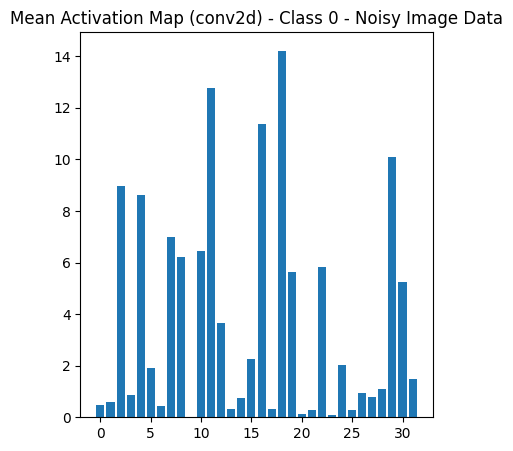

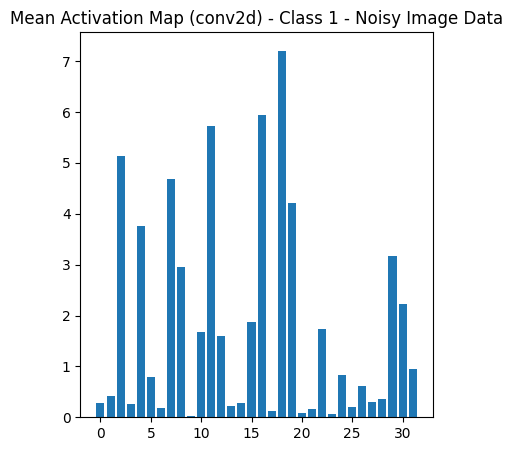

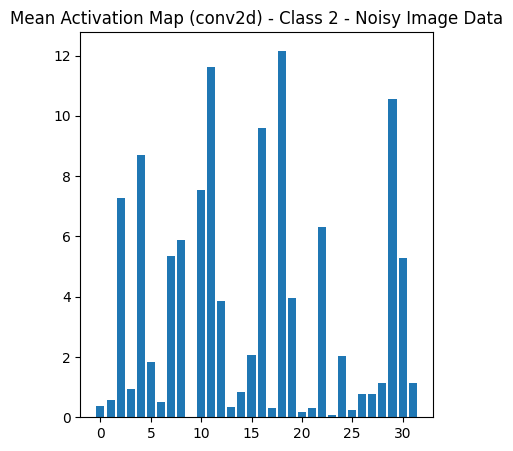

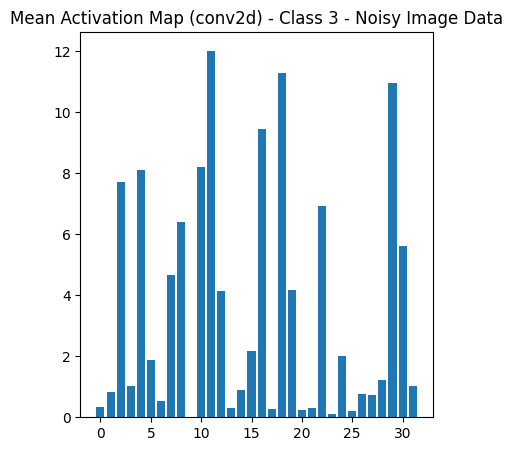

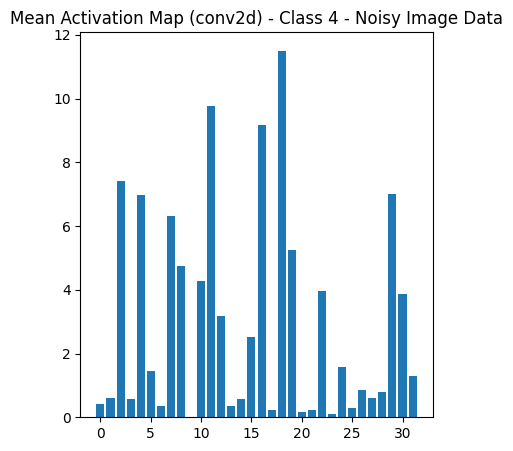

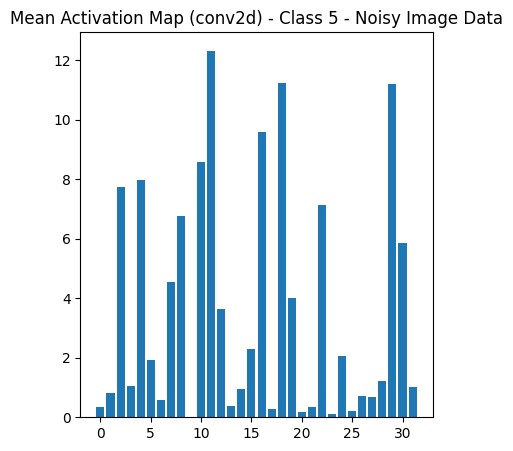

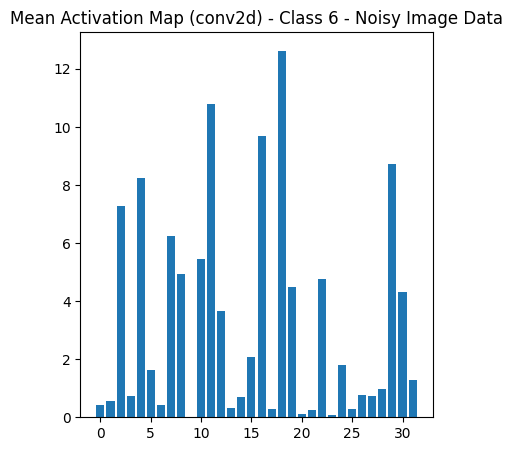

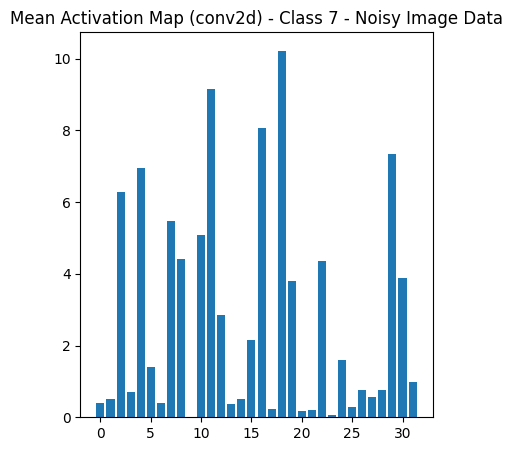

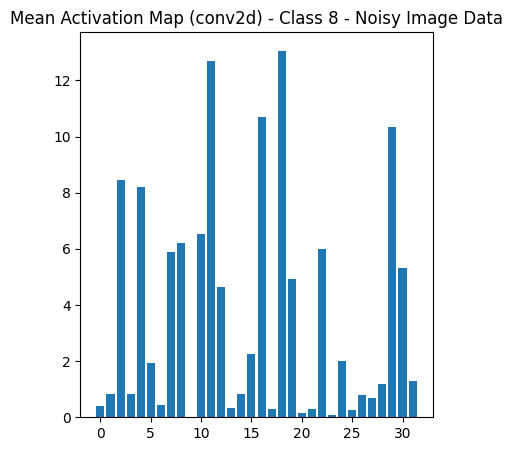

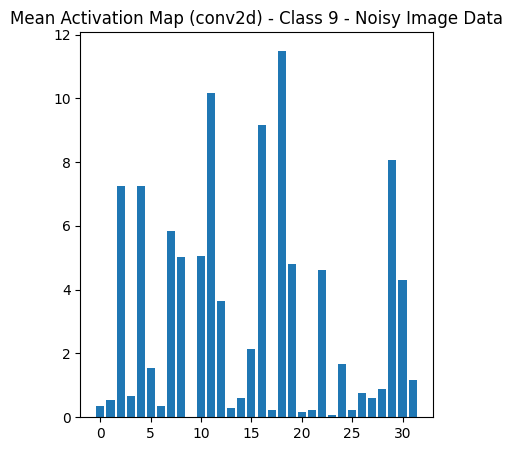

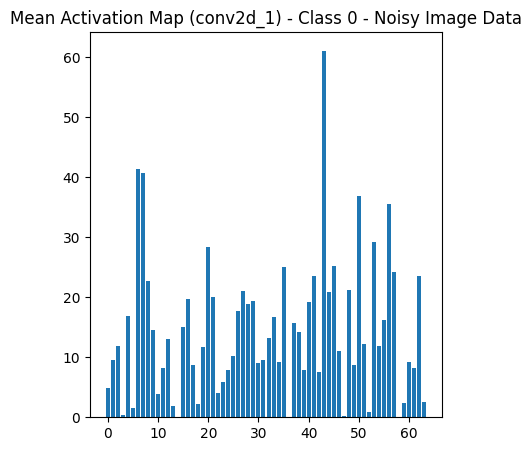

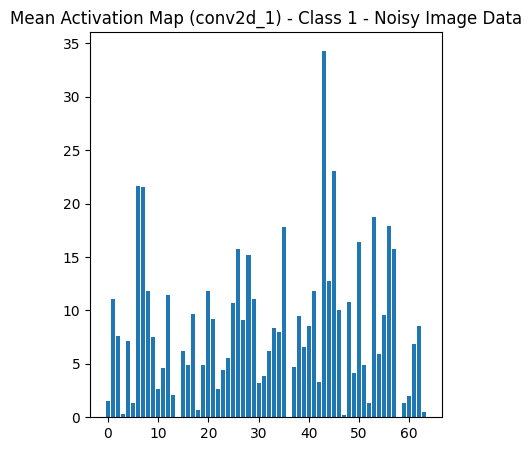

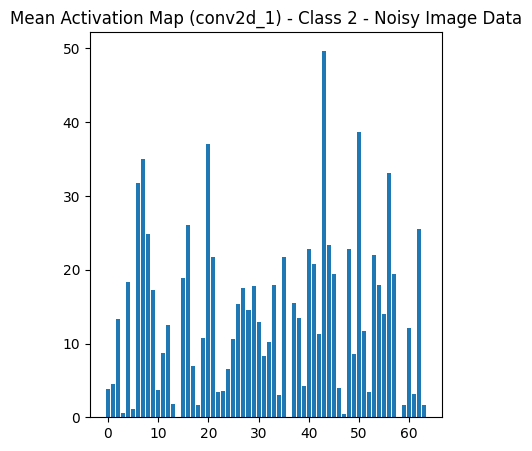

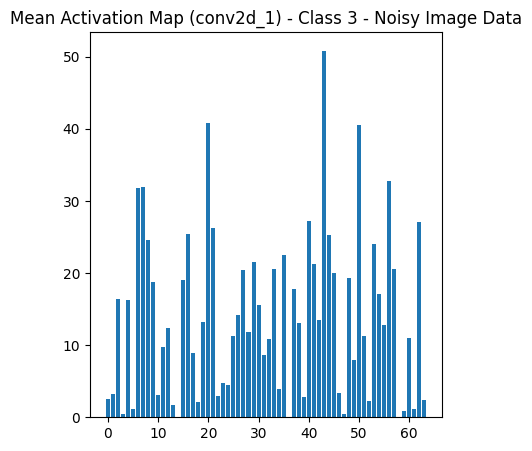

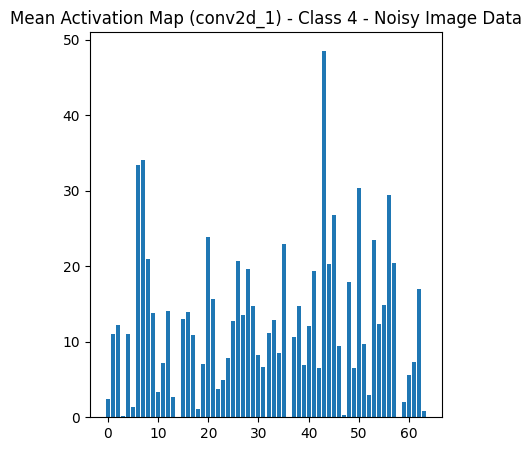

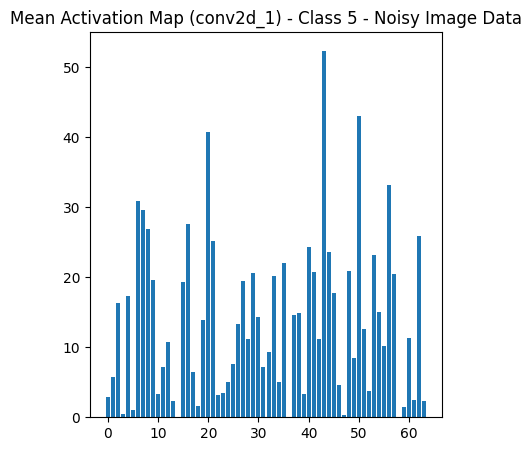

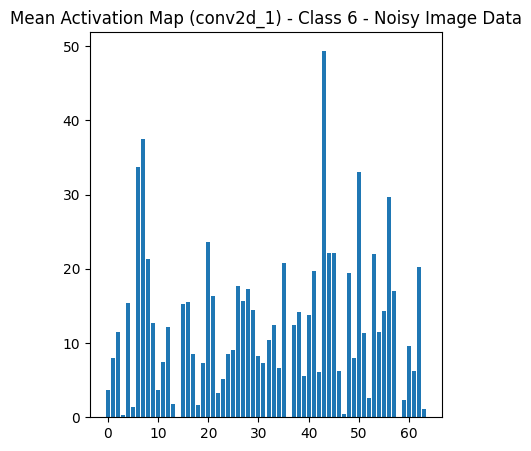

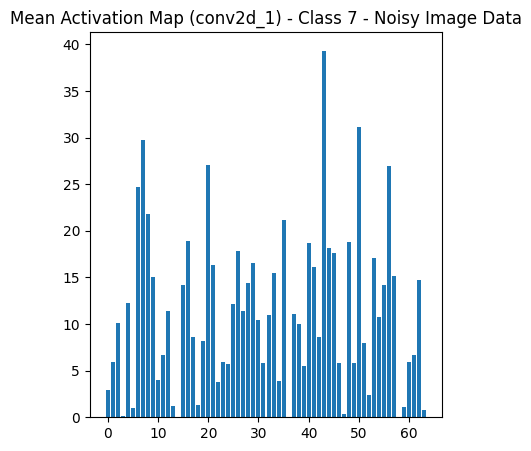

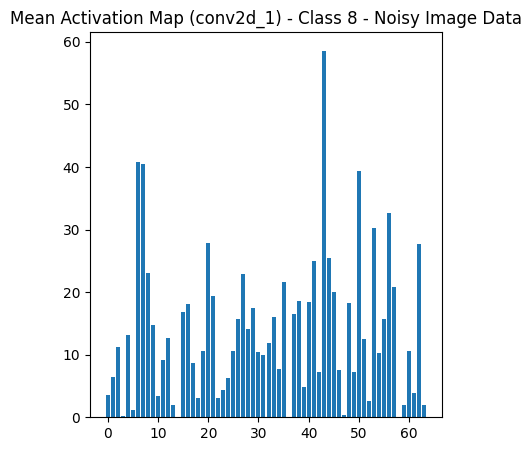

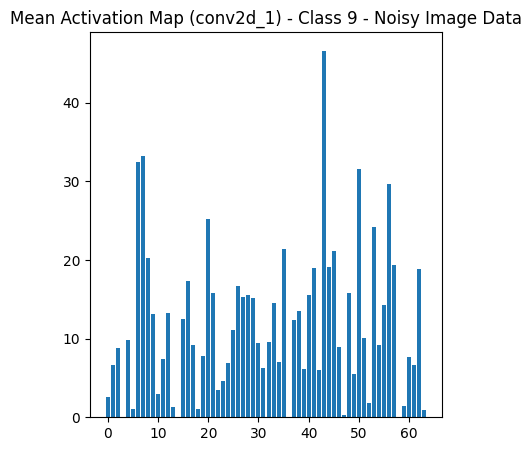

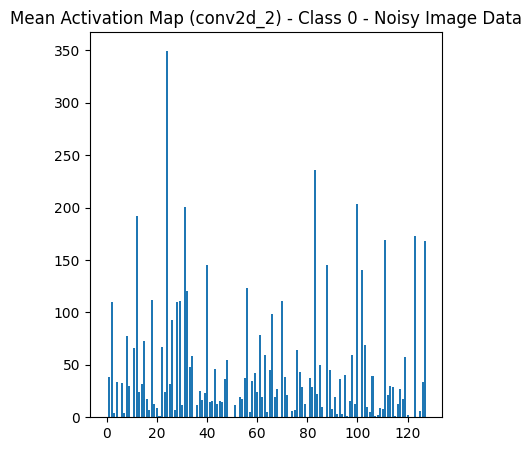

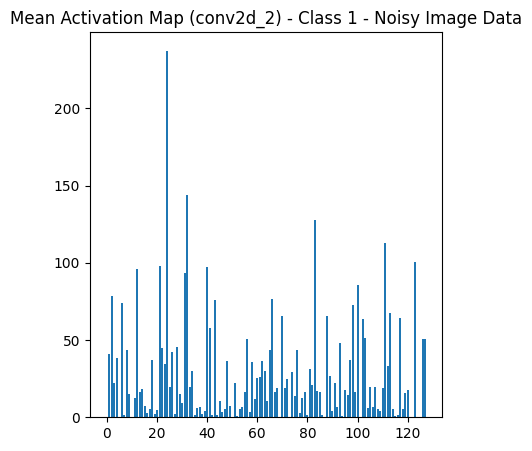

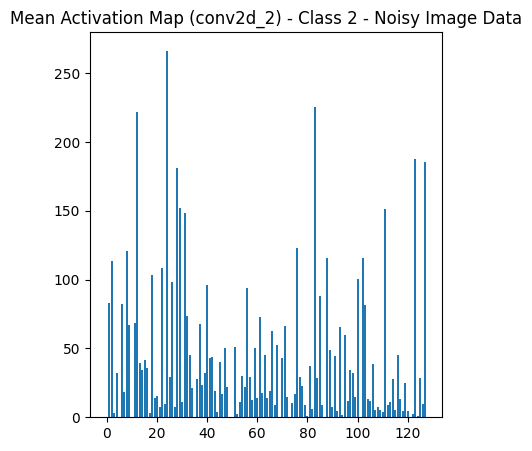

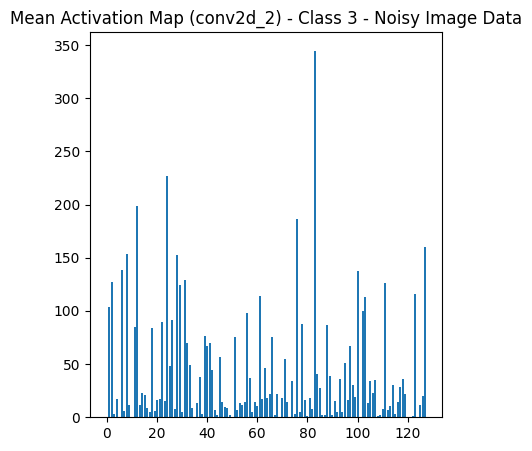

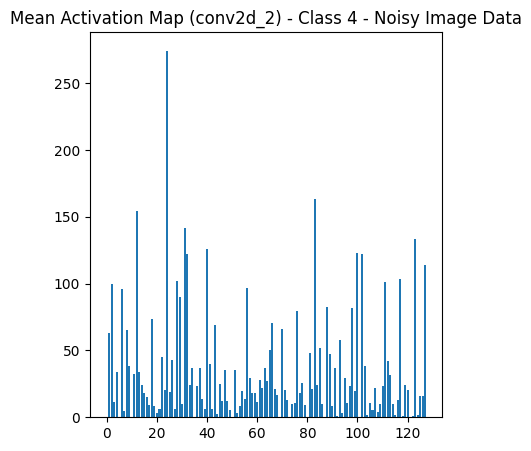

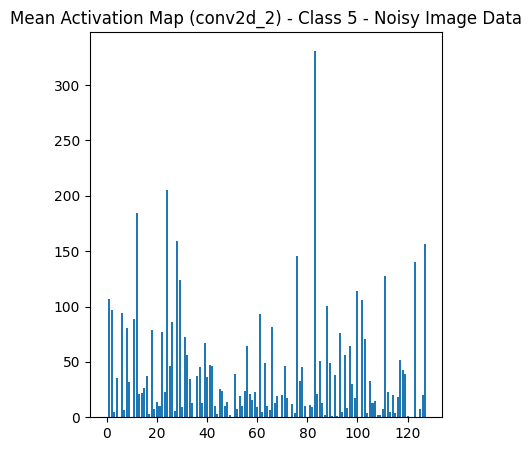

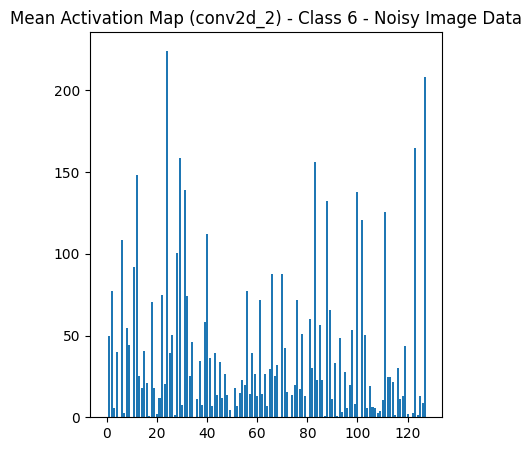

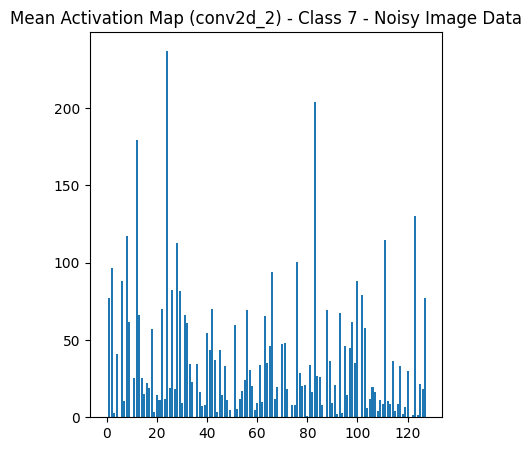

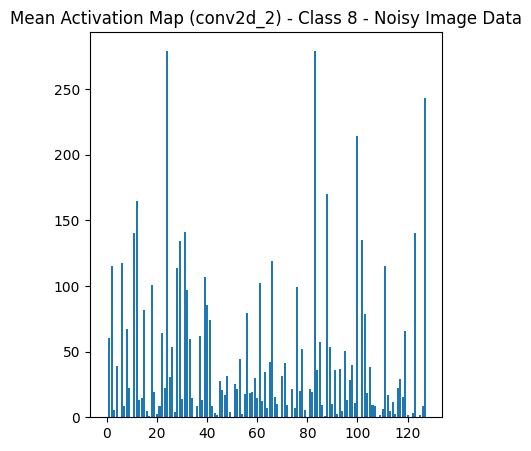

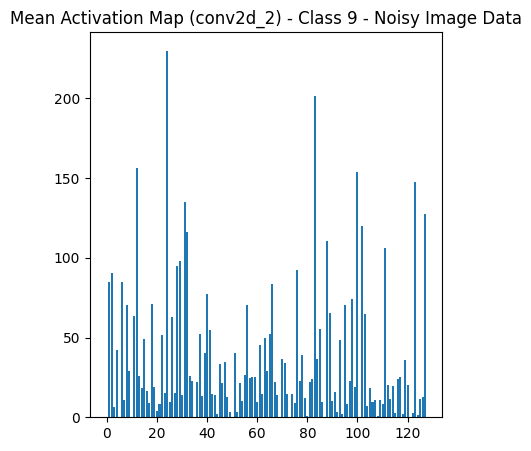

In [10]:
# Define a new Model to get intermediate representations for all layers in the previous model after the first.
successive_outputs = [layer.output for layer in new_model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=new_model.input, outputs=successive_outputs)

# Get the intermediate representations for real data
successive_feature_maps_real = visualization_model.predict(all_noise_maps)

# Retrieve the names of the layers
layer_names = [layer.name for layer in new_model.layers]

# Loop over the layers
for layer_name, feature_map_noise in zip(layer_names, successive_feature_maps_real):
  if 'conv' not in layer_name:
    continue

  # Get the number of filters in the current layer
  n_filters = feature_map_noise.shape[-1]

  # Define the digits to generate noise maps for
  num_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  # Loop over the classes
  for class_idx in num_classes:
    # Select the feature maps that correspond to the target class
    target_indices = np.where(all_labels == class_idx)[0]
    feature_maps_noise = feature_map_noise[target_indices]

    # Get the mean activation maps for real data and noise data separately
    mean_activation_map_noise = np.mean(feature_maps_noise, axis=(0,1,2))

    # Plot the mean activation maps for real and noise data side by side
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title(f"Mean Activation Map ({layer_name}) - Class {class_idx} - Noisy Image Data")
    plt.bar(range(n_filters), mean_activation_map_noise)
    plt.show()
